+ Name: Dong Quan Le
+ ID: s225051626
+ Unit: SIT-307
+ 8.2D

# 1. Melbourne Housing Data acquisition: choose the top three suburbs that you want to live in Melbourne, leverage realestate.com.au to automatically or manually collect at least 150 housing data points (at least 50 for each suburb). For each housing data point, prepare as many features as you can, example features are property type, location, number of bedrooms/bathrooms, land size, sale date, etc. The target variable is sold price

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_json('data/short_dataset_realestateComAu-scraper.json')
print(df.shape)

(475, 20)


In [3]:
print(df.info())
print(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               475 non-null    object
 1   price               467 non-null    object
 2   description         475 non-null    object
 3   constructionStatus  467 non-null    object
 4   channel             475 non-null    object
 5   propertyType        467 non-null    object
 6   landSize            173 non-null    object
 7   address             475 non-null    object
 8   generalFeatures     461 non-null    object
 9   propertyFeatures    456 non-null    object
 10  images              475 non-null    object
 11  agency              475 non-null    object
 12  lister              475 non-null    object
 13  modifiedDate        467 non-null    object
 14  listingId           475 non-null    int64 
 15  signature           475 non-null    bool  
 16  featured            475 no

# 2.Conduct data preprocessing and exploratory data analysis:

### b. Create new features (e.g., number of schools nearby).


In [4]:
drop_cols = [
    'title', 'description', 'channel', 'images', 'agency', 'lister',
    'modifiedDate', 'listingId', 'signature', 'featured', 'productDepth',
    'advertising', 'status'
]

df_clean = df.drop(columns=drop_cols)

print(df_clean.columns.tolist())
print(df_clean.info())
print(df_clean.head(4))

['price', 'constructionStatus', 'propertyType', 'landSize', 'address', 'generalFeatures', 'propertyFeatures']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               467 non-null    object
 1   constructionStatus  467 non-null    object
 2   propertyType        467 non-null    object
 3   landSize            173 non-null    object
 4   address             475 non-null    object
 5   generalFeatures     461 non-null    object
 6   propertyFeatures    456 non-null    object
dtypes: object(7)
memory usage: 26.1+ KB
None
                                               price constructionStatus  \
0  {'display': 'Investor’s Dream, Footsteps from ...        established   
1             {'display': '$2,930,000 - $3,223,000'}        established   
2             {'display': '$5,800,000 - $6,000,000'}        established   
3       

In [5]:
import ast
import re

def parse_obj(x):
    if isinstance(x, float) and np.isnan(x):
        return None
    if isinstance(x, str):
        try:
            return eval(x)  # convert string into Python object
        except:
            return None
    if isinstance(x, (dict, list)):
        return x
    return None
            
def extract_price(x):
    obj = parse_obj(x)
    if obj and isinstance(obj, dict) and "display" in obj:
        price_str = obj["display"]
        numbers = re.findall(r'\d[\d,]*', price_str)
        if numbers:
            nums = [int(n.replace(',', '')) for n in numbers]
            return sum(nums)/len(nums)  # average if range
    return None

def extract_land_size(x):
    obj = parse_obj(x)
    if obj and isinstance(obj, dict) and "displayAppAbbreviated" in obj:
        land_str = obj["displayAppAbbreviated"]
        numbers = re.findall(r'\d[\d,]*', land_str)
        if numbers:
            return float(numbers[0].replace(',', ''))
    return None

def extract_suburb(x):
    obj = parse_obj(x)
    if obj and isinstance(obj, dict):
        return obj.get("suburb")
    return None

def extract_general(x):
    obj = parse_obj(x)
    out = {"bedrooms": None, "bathrooms": None, "carspaces": None}
    if obj and isinstance(obj, dict):
        if "bedrooms" in obj and "value" in obj["bedrooms"]:
            out["bedrooms"] = obj["bedrooms"]["value"]
        if "bathrooms" in obj and "value" in obj["bathrooms"]:
            out["bathrooms"] = obj["bathrooms"]["value"]
        if "parkingSpaces" in obj and "value" in obj["parkingSpaces"]:
            out["carspaces"] = obj["parkingSpaces"]["value"]
    return out

def extract_property_features(x):
    obj = parse_obj(x)
    features = {"garage_spaces": 0, "has_pool": 0}
    if obj and isinstance(obj, list):
        for section in obj:
            if "features" in section:
                for feat in section["features"]:
                    if "Garage" in feat:
                        num = re.findall(r'\d+', feat)
                        features["garage_spaces"] = int(num[0]) if num else 1
                    if "Pool" in feat:
                        features["has_pool"] = 1
    return features


In [6]:
df_transformed = df_clean.copy()
df_transformed["price_numeric"] = df_transformed["price"].apply(extract_price)
df_transformed["landSize_sqm"] = df_transformed["landSize"].apply(extract_land_size)
df_transformed["suburb"] = df_transformed["address"].apply(extract_suburb)

general = df_transformed["generalFeatures"].apply(extract_general).apply(pd.Series)
df_transformed = pd.concat([df_transformed, general], axis=1)

prop_feats = df_transformed["propertyFeatures"].apply(extract_property_features).apply(pd.Series)
df_transformed = pd.concat([df_transformed, prop_feats], axis=1)

final_cols = ["price_numeric", "constructionStatus", "propertyType",
              "landSize_sqm", "suburb", "bedrooms", "bathrooms", "carspaces",
              "garage_spaces", "has_pool"]
df_final = df_transformed[final_cols]
print(df_final.info())
print(df_final.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_numeric       373 non-null    float64
 1   constructionStatus  467 non-null    object 
 2   propertyType        467 non-null    object 
 3   landSize_sqm        173 non-null    float64
 4   suburb              475 non-null    object 
 5   bedrooms            461 non-null    float64
 6   bathrooms           461 non-null    float64
 7   carspaces           435 non-null    float64
 8   garage_spaces       475 non-null    int64  
 9   has_pool            475 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 37.2+ KB
None
   price_numeric constructionStatus      propertyType  landSize_sqm   suburb  \
0            NaN        established              unit         303.0  Burwood   
1      3076500.0        established             house        1992.0  Burwood   

In [7]:
#Fill Null values
df_filled = df_final.copy()
num_cols = ["price_numeric", "landSize_sqm", "bedrooms", "bathrooms", "carspaces"]
for col in num_cols:
    df_filled[col] = df_filled[col].fillna(df_filled[col].median())
    
cat_cols = ["constructionStatus", "propertyType", "suburb"]
for col in cat_cols:
    df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])

print(df_filled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_numeric       475 non-null    float64
 1   constructionStatus  475 non-null    object 
 2   propertyType        475 non-null    object 
 3   landSize_sqm        475 non-null    float64
 4   suburb              475 non-null    object 
 5   bedrooms            475 non-null    float64
 6   bathrooms           475 non-null    float64
 7   carspaces           475 non-null    float64
 8   garage_spaces       475 non-null    int64  
 9   has_pool            475 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 37.2+ KB
None


### a. Convert categorical variables (e.g. unit/house/apartment) using one-hot encoding.

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first")
encoded = encoder.fit_transform(df_filled[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index= df_filled.index)
df_encoded = pd.concat([df_filled.drop(columns=cat_cols), encoded_df], axis=1)

print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price_numeric                      475 non-null    float64
 1   landSize_sqm                       475 non-null    float64
 2   bedrooms                           475 non-null    float64
 3   bathrooms                          475 non-null    float64
 4   carspaces                          475 non-null    float64
 5   garage_spaces                      475 non-null    int64  
 6   has_pool                           475 non-null    int64  
 7   constructionStatus_new             475 non-null    float64
 8   propertyType_duplex/semi-detached  475 non-null    float64
 9   propertyType_house                 475 non-null    float64
 10  propertyType_other                 475 non-null    float64
 11  propertyType_residential land      475 non-null    float64

### c. Normalize or standardize numerical features.


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
num_cols = ["price_numeric", "landSize_sqm", "bedrooms", "bathrooms", "carspaces", "garage_spaces"]
scaler = StandardScaler()
y_scaler = StandardScaler().fit(df_encoded[["price_numeric"]])
df_std = df_encoded.copy()
scaler.fit(df_encoded[num_cols])
df_std[num_cols] = scaler.fit_transform(df_encoded[num_cols])
print(df_std.head(3))


   price_numeric  landSize_sqm  bedrooms  bathrooms  carspaces  garage_spaces  \
0      -0.222616     -1.235875  0.918206   0.174391  -0.643729       0.038885   
1       3.678321      6.855721  0.918206   1.264334   4.209784       0.038885   
2       8.245726      5.911941  0.117935   0.174391  -0.643729      -1.047597   

   has_pool  constructionStatus_new  propertyType_duplex/semi-detached  \
0         0                     0.0                                0.0   
1         0                     0.0                                0.0   
2         0                     0.0                                0.0   

   propertyType_house  ...  suburb_Dingley Village  suburb_Glen Iris  \
0                 0.0  ...                     0.0               0.0   
1                 1.0  ...                     0.0               0.0   
2                 0.0  ...                     0.0               0.0   

   suburb_Keysborough  suburb_Mount Waverley  suburb_Mulgrave  \
0                 0.0   

### d. Visualize housing price distributions, feature to target correlations, and outliers.

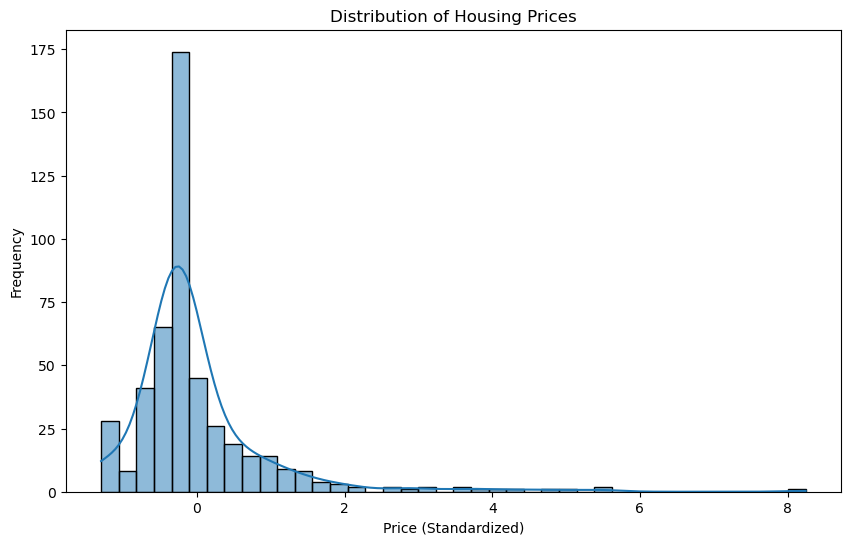

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(df_std['price_numeric'], kde=True, bins = 40)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price (Standardized)')
plt.ylabel('Frequency')
plt.show()


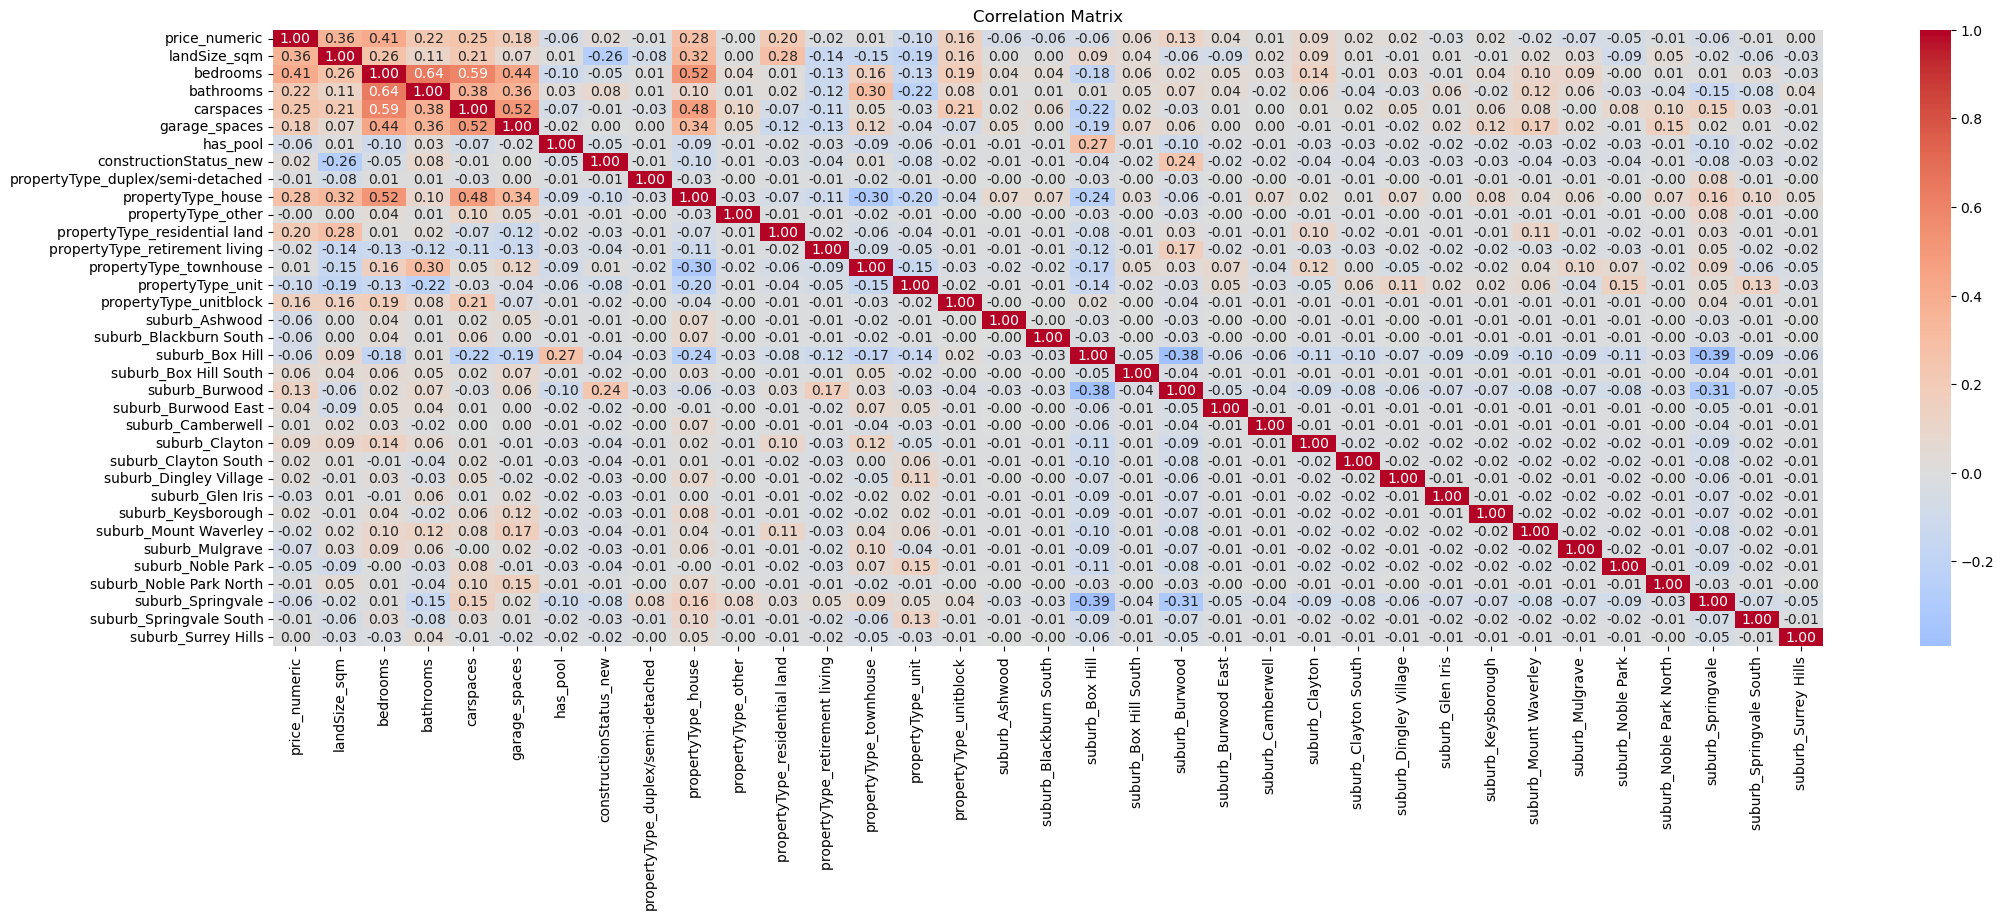

Correlation of features with Price:
price_numeric                        1.000000
bedrooms                             0.408399
landSize_sqm                         0.360545
propertyType_house                   0.275567
carspaces                            0.248986
bathrooms                            0.218148
propertyType_residential land        0.199549
garage_spaces                        0.178237
propertyType_unitblock               0.155824
suburb_Burwood                       0.128530
suburb_Clayton                       0.087212
suburb_Box Hill South                0.058367
suburb_Burwood East                  0.040232
constructionStatus_new               0.022842
suburb_Clayton South                 0.020290
suburb_Dingley Village               0.018917
suburb_Keysborough                   0.015931
suburb_Camberwell                    0.012129
propertyType_townhouse               0.007489
suburb_Surrey Hills                  0.003467
propertyType_other                  -0.00168

In [11]:
# Feature to Target Correlations
# Correlation matrix
corr = df_encoded.corr(numeric_only=True)

plt.figure(figsize=(25,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Correlation of features vs price only
price_corr = corr["price_numeric"].sort_values(ascending=False)
print("Correlation of features with Price:")
print(price_corr)


### e. Identify price trends over time across suburbs.

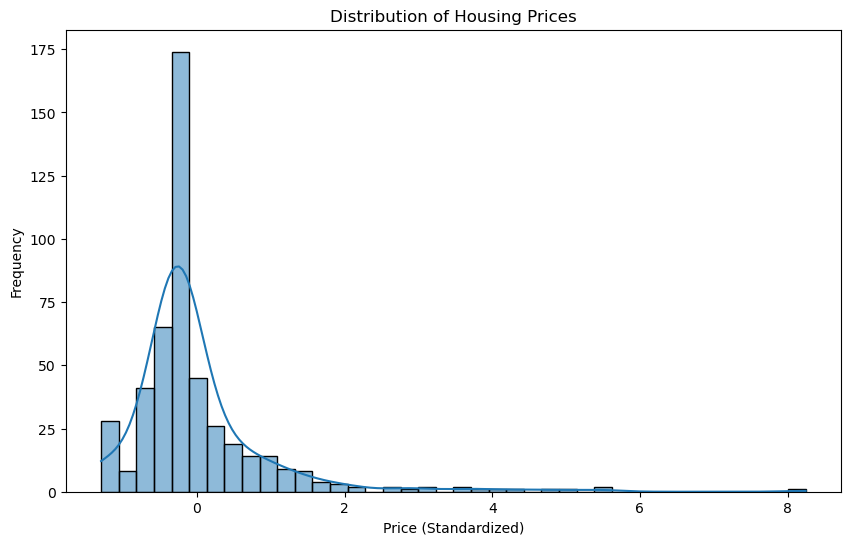

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(df_std['price_numeric'], kde=True, bins = 40)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price (Standardized)')
plt.ylabel('Frequency')
plt.show()


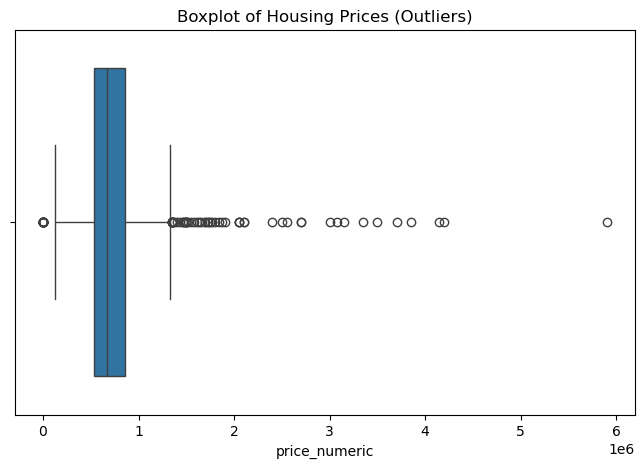

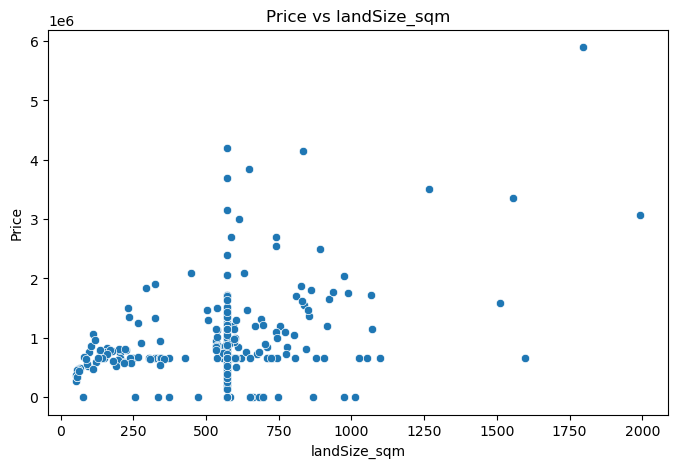

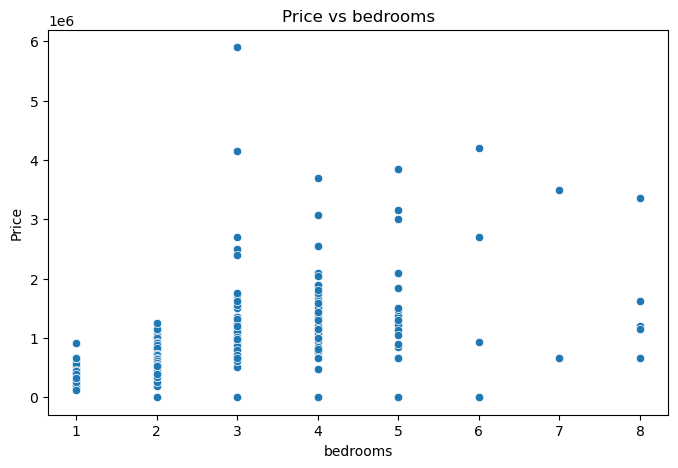

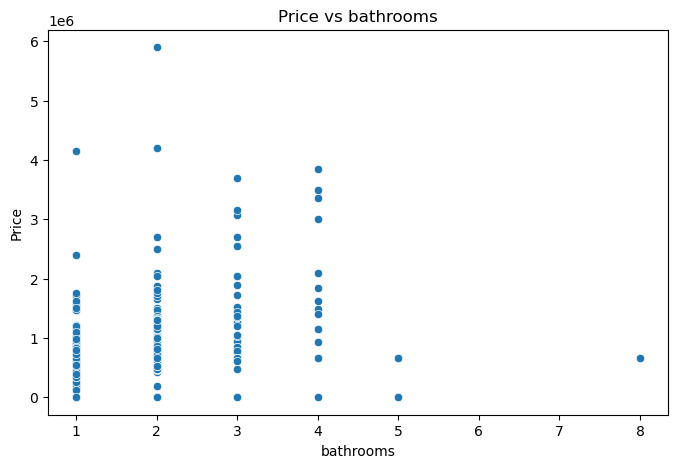

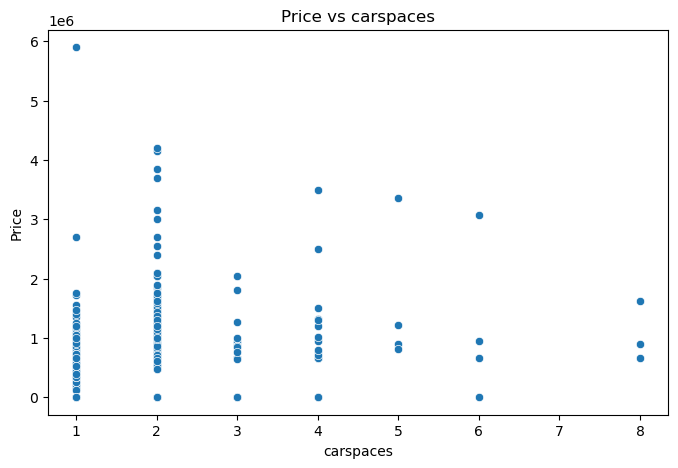

In [13]:
#Outlier Detection
# Boxplot for price
plt.figure(figsize=(8,5))
sns.boxplot(x=df_encoded["price_numeric"])
plt.title("Boxplot of Housing Prices (Outliers)")
plt.show()

# Boxplots for numeric features vs price
num_features = ["landSize_sqm", "bedrooms", "bathrooms", "carspaces"]

for col in num_features:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df_encoded[col], y=df_encoded["price_numeric"])
    plt.title(f"Price vs {col}")
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.show()

C:\Users\windows\AppData\Local\Temp\ipykernel_17196\1604061978.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['startTime'] = time_data
C:\Users\windows\AppData\Local\Temp\ipykernel_17196\1604061978.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['month'] = df_final['startTime'].dt.to_period('M')
C:\Users\windows\AppData\Local\Temp\ipykernel_17196\1604061978.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

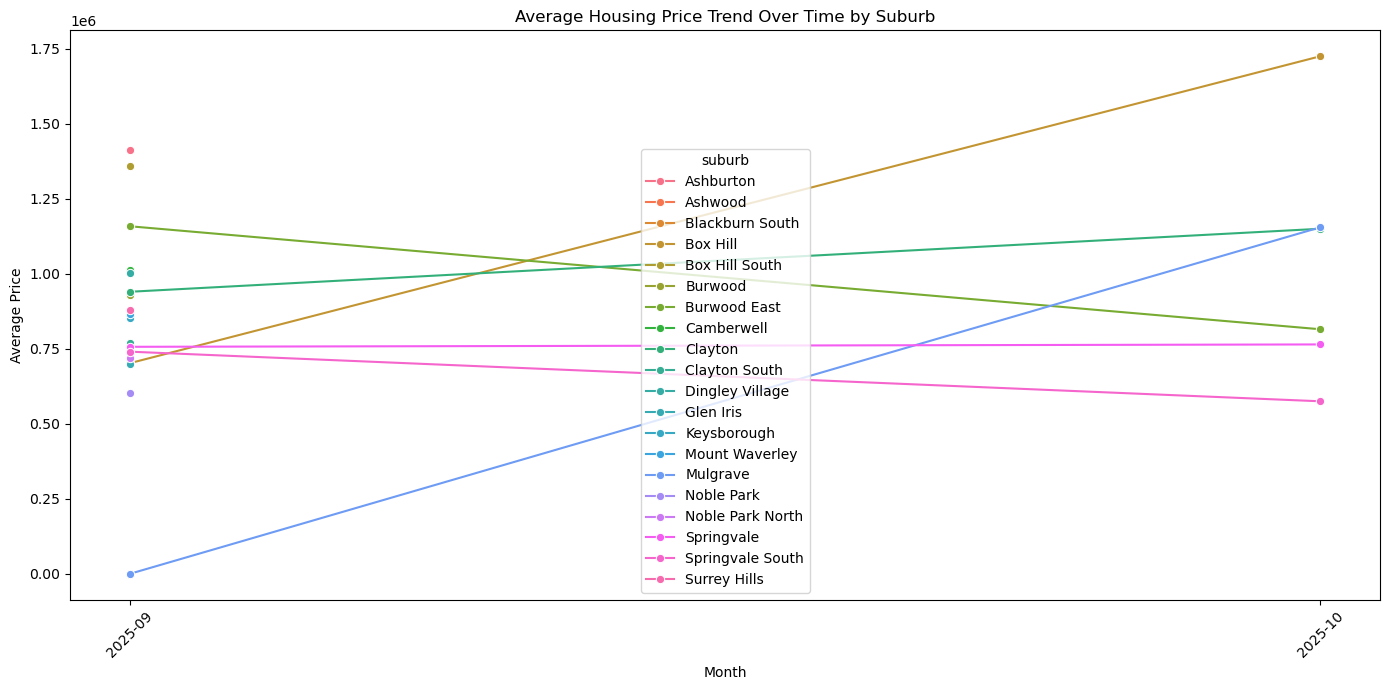

In [14]:
with open("data/dataset_realestateComAu-scraper_2025-09-12_14-24-48-348.json") as f:
    json_data = json.load(f)

time_data = []
for item in json_data:
    inspections = item.get('inspectionsAndAuctions', [])
    if inspections:
        start_time = inspections[0].get('startTime', None)
        time_data.append(pd.to_datetime(start_time))
    else:
        time_data.append(pd.NaT)  

df_final['startTime'] = time_data
df_final['month'] = df_final['startTime'].dt.to_period('M')

df_final_clean = df_final.dropna(subset=['price_numeric','month'])
df_final_clean['month_str'] = df_final_clean['month'].astype(str)

price_trends = df_final_clean.groupby(['month_str', 'suburb'])['price_numeric'].mean().reset_index()

plt.figure(figsize=(14,7))
sns.lineplot(data=price_trends, x='month_str', y='price_numeric', hue='suburb', marker='o')
plt.title('Average Housing Price Trend Over Time by Suburb')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Model development: develop at least three different regression models, use MAE, RMSE and R-squared as the evaluation metrics, use k-fold cross validation to evaluate the model performance

In [15]:
from sklearn.model_selection import train_test_split
y = df_std["price_numeric"]
#Keep rows where price is not null
X = df_encoded.loc[y.index].drop(columns=["price_numeric"])
print(X.shape, y.shape)
print(y)


(475, 34) (475,)
0     -0.222616
1      3.678321
2      8.245726
3      1.451641
4     -0.060852
         ...   
470    0.642821
471    0.804585
472    0.011942
473   -0.440997
474   -0.222616
Name: price_numeric, Length: 475, dtype: float64


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
# Define 3 models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=18),
    "Decision Tree": DecisionTreeRegressor(random_state=18)
}
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
# Define 3 scoring metrics
scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(rmse, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        mean_score = np.mean(scores)
        results.append({
            "Model": name,
            "Metric": metric_name,
            "Score": abs(mean_score) if metric_name in ["MAE", "RMSE"] else mean_score
        })

df_results = pd.DataFrame(results)
df_pivot = df_results.pivot(index="Model", columns="Metric", values="Score")
print(df_pivot)


# 4. Feature importance: identify which features more influence housing price, use model-specific methods (e.g., feature importance in tree-based methods) or other statistical methods (e.g., SHAP values).

In [ ]:
models["Random Forest"].fit(X, y)
rf_importances = pd.Series(models["Random Forest"].feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=False)
print("Random Forest Feature Importances:")
print(rf_importances)

plt.figure(figsize=(10,6))
rf_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.show()


In [ ]:
models["Decision Tree"].fit(X, y)
rf_importances = pd.Series(models["Decision Tree"].feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=False)
print("Decision Tree Feature Importances:")
print(rf_importances)

plt.figure(figsize=(10,6))
rf_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Decision Tree Feature Importance")
plt.show()


In [ ]:
model = models["Linear Regression"].fit(X, y)
lr_coeffs = pd.Series(models["Linear Regression"].coef_, index=X.columns)
lr_coeffs = lr_coeffs.sort_values(key=abs, ascending=False)

print("Linear Regression Coefficients (scaled features):")
print(lr_coeffs)

plt.figure(figsize=(10,6))
lr_coeffs.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Decision Tree Feature Importance")
plt.show()

# 5. Model deployment: Develop a simple web demo application using appropriate packages (e.g., gradio, Flask or Streamlit). Allow users to input property features and receive price predictions.

In [ ]:
rf_model = models["Random Forest"].fit(X, y)
lr_model = models["Linear Regression"].fit(X, y)
dt_model = models["Decision Tree"].fit(X, y)


In [ ]:
import joblib

# Save model
joblib.dump(rf_model, 'rf_housing_model.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(y_scaler, 'scaler.pkl')
# Later, load it
model = joblib.load('rf_housing_model.pkl')


In [ ]:
import gradio as gr

# Load the trained model
model = joblib.load("rf_housing_model.pkl")
encoder = joblib.load("encoder.pkl")
scaler = joblib.load("scaler.pkl")

feature_names = [
    "landSize_sqm", "bedrooms", "bathrooms", "carspaces", "garage_spaces",
    "has_pool", "constructionStatus_new",
    "propertyType_duplex/semi-detached", "propertyType_house", "propertyType_other",
    "propertyType_residential land", "propertyType_retirement living",
    "propertyType_townhouse", "propertyType_unit", "propertyType_unitblock",
    "suburb_Ashwood", "suburb_Blackburn South", "suburb_Box Hill", "suburb_Box Hill South",
    "suburb_Burwood", "suburb_Burwood East", "suburb_Camberwell", "suburb_Clayton",
    "suburb_Clayton South", "suburb_Dingley Village", "suburb_Glen Iris",
    "suburb_Keysborough", "suburb_Mount Waverley", "suburb_Mulgrave",
    "suburb_Noble Park", "suburb_Noble Park North", "suburb_Springvale",
    "suburb_Springvale South", "suburb_Surrey Hills"
]

def predict_price(landSize, bedrooms, bathrooms, carspaces, garage, has_pool, 
                  constructionStatus, propertyType, suburb):
    input_data = pd.DataFrame([[0]*len(feature_names)], columns=feature_names)

    # numeric features
    input_data["landSize_sqm"] = landSize
    input_data["bedrooms"] = bedrooms
    input_data["bathrooms"] = bathrooms
    input_data["carspaces"] = carspaces
    input_data["garage_spaces"] = garage
    input_data["has_pool"] = int(has_pool)

    # one-hot categorical features
    const_col = f"constructionStatus_{constructionStatus}"
    prop_col = f"propertyType_{propertyType}"
    suburb_col = f"suburb_{suburb}"

    for col in [const_col, prop_col, suburb_col]:
        if col in input_data.columns:
            input_data[col] = 1

    # prediction
    pred = model.predict(input_data)[0]
    pred_original = scaler.inverse_transform([[pred]])[0][0]
    print(gr.Error())
    return f"Predicted price: ${pred_original:,.0f}"
    sca

demo = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Land Size (sqm)"),
        gr.Number(label="Bedrooms"),
        gr.Number(label="Bathrooms"),
        gr.Number(label="Car Spaces"),
        gr.Number(label="Garage Spaces"),
        gr.Checkbox(label="Has Pool"),
        gr.Dropdown(["new", "established"], label="Construction Status"),
        gr.Dropdown(["duplex/semi-detached","house","other","residential land",
                     "retirement living","townhouse","unit","unitblock"], 
                     label="Property Type"),
        gr.Dropdown([
            "Ashwood","Blackburn South","Box Hill","Box Hill South","Burwood",
            "Burwood East","Camberwell","Clayton","Clayton South","Dingley Village",
            "Glen Iris","Keysborough","Mount Waverley","Mulgrave","Noble Park",
            "Noble Park North","Springvale","Springvale South","Surrey Hills"
        ], label="Suburb")
    ],
    outputs="text",
    title=" Melbourne Housing Price Predictor"
)

demo.launch(share=True)
